## The project: End-to-End ML Experimentation, Deployment, and Monitoring Pipeline for the Iris Dataset

This project demonstrates a **complete machine learning lifecycle** — from training and experiment tracking to deployment, online A/B testing, and production monitoring with explainability and drift detection.

---

### 1. **Experiment Tracking with MLflow**

* The system trains two models on the **Iris dataset**:
  **v1:** Logistic Regression
  **v2:** Random Forest

* Each training run is logged using **MLflow**, including:

  * Model parameters
  * Validation accuracy
  * Artifacts (saved `.joblib` models)
  * Optional registration in the MLflow Model Registry

* The results are stored locally under the `./mlruns` directory.

---

### 2. **Deployment with FastAPI and Canary Release**

* A **FastAPI** application exposes a REST API for model predictions.
* Requests are randomly routed to:

  * **v1** (80% of traffic)
  * **v2** (20% of traffic)
    This simulates a **Canary Deployment**, allowing gradual rollout of a new model.
* **Ngrok** provides a public HTTPS tunnel for testing without a real cloud deployment.
  The authentication token is loaded securely from a local file:

  ```bash
  env_ngrok
  └── NGROK_AUTH_TOKEN=your_token_here
  ```

---

### 3. **Online A/B Testing and Monitoring**

* The monitoring script sends multiple requests to the API, logs responses, and measures:

  * Latency per request
  * Accuracy per model
  * Model usage ratio

* Key metrics such as mean latency and 95th percentile latency (P95) are calculated.

* Two plots are generated:

  * **Accuracy comparison** between model versions
  * **Latency histogram** for v1 vs v2

* Logs are stored in `ab_test_log.json` for further analysis.

---

### 4. **Explainability with SHAP**

* Model **v2 (Random Forest)** is analyzed using **SHAP (SHapley Additive Explanations)** to interpret feature importance.
* The script generates a **SHAP summary plot** showing which features most strongly influence predictions (e.g., *petal length* and *petal width*).

---

### 5. **Drift Detection with Population Stability Index (PSI)**

* The project calculates **PSI** between:

  * The original training distribution (Iris dataset)
  * The production data collected from live API requests

* Drift is assessed per feature:

  * **PSI < 0.1:** No drift
  * **0.1 ≤ PSI ≤ 0.25:** Moderate drift
  * **PSI > 0.25:** Significant drift

This enables continuous monitoring of **data distribution changes** that may impact model performance.

---

### 6. **Key Takeaways**

* **MLflow** ensures reproducible experiments and model versioning.
* **FastAPI + ngrok** provides rapid prototyping and real-time model testing.
* **Canary rollout** enables safe gradual deployment of new model versions.
* **A/B testing and SHAP** provide transparent performance and interpretability.
* **PSI drift metrics** add early warning for model degradation.

---

**Overall**, this project integrates model training, deployment, monitoring, and explainability into one unified pipeline — a minimal yet production-oriented demonstration of **MLOps best practices**.


## The dataset: Iris Flower Classification

The project uses the **Iris dataset**, a classic benchmark in machine learning that contains measurements of three flower species:
**Setosa**, **Versicolor**, and **Virginica**.

Each row represents one flower sample, with the following numeric feature columns:

| Feature             | Description               | Unit        |
| ------------------- | ------------------------- | ----------- |
| `sepal length (cm)` | Length of the outer sepal | centimeters |
| `sepal width (cm)`  | Width of the outer sepal  | centimeters |
| `petal length (cm)` | Length of the inner petal | centimeters |
| `petal width (cm)`  | Width of the inner petal  | centimeters |

The **label (`target`)** column indicates the flower species:

* `0` → *Setosa*
* `1` → *Versicolor*
* `2` → *Virginica*

This dataset is used to train and evaluate the classification models (`LogisticRegression` and `RandomForest`) in the project’s A/B testing and deployment pipeline.


In [ ]:
# ===========================================
# Clean environment and install compatible versions
# ===========================================
!pip install numpy==1.26.4 scikit-learn==1.5.1 mlflow==2.14.3 joblib==1.4.2

In [2]:

import os, joblib, numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import mlflow
import mlflow.sklearn

# ===========================================
# MLflow setup
# ===========================================
mlflow.set_tracking_uri("file://" + os.path.abspath("./mlruns"))
mlflow.set_experiment("iris_abtest_experiment")

# ===========================================
# Data loading
# ===========================================
iris = load_iris()
X, y = iris.data, iris.target
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ===========================================
# Training + Logging function
# ===========================================
def train_and_log(model, name):
    with mlflow.start_run(run_name=name):
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)

        # Log parameters and metrics
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())
        mlflow.log_metric("val_accuracy", float(acc))

        # Save artifacts
        path = f"{name}.joblib"
        joblib.dump(model, path)
        mlflow.log_artifact(path)

        # Optional registration (works only in server mode)
        model_uri = mlflow.get_artifact_uri(path)
        registered_name = f"iris_model_{name}"
        try:
            mlflow.register_model(model_uri=model_uri, name=registered_name)
        except Exception:
            pass

        print(f"{name}: val_accuracy={acc:.4f}, saved to {path}")
        return path, acc

# ===========================================
# Train two models and log
# ===========================================
path_v1, acc_v1 = train_and_log(LogisticRegression(max_iter=200), name="v1_logreg")
path_v2, acc_v2 = train_and_log(RandomForestClassifier(n_estimators=120, random_state=42), name="v2_rf")

print("Artifacts:", path_v1, path_v2)


2025/10/23 07:04:49 INFO mlflow.tracking.fluent: Experiment with name 'iris_abtest_experiment' does not exist. Creating a new experiment.
Successfully registered model 'iris_model_v1_logreg'.
Created version '1' of model 'iris_model_v1_logreg'.


v1_logreg: val_accuracy=0.9474, saved to v1_logreg.joblib
v2_rf: val_accuracy=0.8947, saved to v2_rf.joblib
Artifacts: v1_logreg.joblib v2_rf.joblib


Successfully registered model 'iris_model_v2_rf'.
Created version '1' of model 'iris_model_v2_rf'.


In [8]:
# ===========================================
# Deployment (FastAPI + ngrok)
# ===========================================
#!pip install -q fastapi uvicorn nest_asyncio pyngrok==7.0.0 python-dotenv

import os, threading, time, joblib, numpy as np
from fastapi import FastAPI
from pydantic import BaseModel
import nest_asyncio
from pyngrok import ngrok, conf
import uvicorn
from sklearn.datasets import load_iris
from dotenv import load_dotenv

# Load ngrok token from local file "env_ngrok"
# The file should contain a line: NGROK_AUTH_TOKEN=your_token_here
load_dotenv("env_ngrok")
ngrok_token = os.getenv("NGROK_AUTH_TOKEN")

if not ngrok_token:
    raise ValueError("Missing NGROK_AUTH_TOKEN in env_ngrok file.")
conf.get_default().auth_token = ngrok_token


# Load once on server start for better latency
iris = load_iris()
model_v1 = joblib.load("v1_logreg.joblib")
model_v2 = joblib.load("v2_rf.joblib")

# Basic request schema
class FeaturesRequest(BaseModel):
    features: list[float]

# Canary split in percent for v2
CANARY_PCT = 0.2

app = FastAPI(title="Iris Canary API")

@app.get("/")
def root():
    return {"message": "Iris Canary API", "canary_pct_v2": CANARY_PCT}

@app.post("/predict")
def predict(req: FeaturesRequest):
    import random
    use_v2 = random.random() < CANARY_PCT
    m = model_v2 if use_v2 else model_v1
    x = np.array(req.features).reshape(1, -1)
    pred = int(m.predict(x)[0])
    return {
        "model_used": "v2" if use_v2 else "v1",
        "prediction": iris.target_names[pred]
    }

# Clean previous port and tunnels, then serve
!fuser -k 8000/tcp || true
ngrok.kill()
public_url = ngrok.connect(8000)
print("Public URL:", public_url)
nest_asyncio.apply()

def run():
    uvicorn.run(app, host="0.0.0.0", port=8000, log_level="info")

thread = threading.Thread(target=run, daemon=True)
thread.start()

# Optional quick health check delay
time.sleep(2)


INFO:     Started server process [5126]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Public URL: NgrokTunnel: "https://def3c2c29c79.ngrok-free.app" -> "http://localhost:8000"


Sending test requests to: https://def3c2c29c79.ngrok-free.app/predict
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.201.202.167:0 - "POST /predict HTTP/1.1" 200 OK
INFO:     35.20

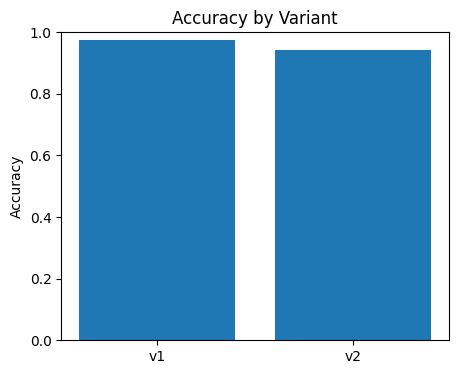

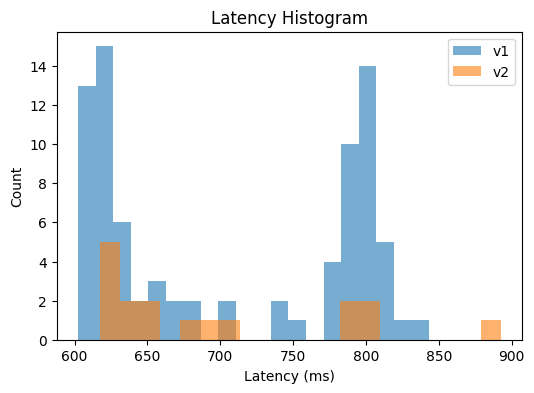

In [9]:
# ===========================================
# Monitoring (traffic, logs, A/B analysis)
# ===========================================

import requests, time, json, statistics, math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

URL = public_url.public_url + "/predict"

print("Sending test requests to:", URL)
iris = load_iris()
X, y, names = iris.data, iris.target, iris.target_names

N = 100
TIMEOUT = 15
logs = []
v1_times, v2_times = [], []
v1_ok = v2_ok = 0
v1_n = v2_n = 0

for i in range(N):
    xi = X[i % len(X)].tolist()
    yi = names[y[i % len(X)]]
    t0 = time.time()
    r = requests.post(URL, json={"features": xi}, timeout=TIMEOUT)
    dt = (time.time() - t0) * 1000.0
    if r.status_code != 200:
        continue
    payload = r.json()
    model_used = payload.get("model_used")
    pred = payload.get("prediction")
    correct = pred == yi
    logs.append({
        "i": i, "model_used": model_used, "latency_ms": dt,
        "prediction": pred, "true_label": yi, "correct": correct,
        "features": xi
    })
    if model_used == "v1":
        v1_n += 1; v1_times.append(dt); v1_ok += int(correct)
    else:
        v2_n += 1; v2_times.append(dt); v2_ok += int(correct)

with open("ab_test_log.json", "w") as f:
    json.dump(logs, f, indent=2)

def mean(a):
    return sum(a)/len(a) if a else float("nan")
def p95(a):
    if not a: return float("nan")
    s = sorted(a); k = int(math.ceil(0.95*len(s)))-1
    return s[max(0, min(k, len(s)-1))]

acc_v1 = v1_ok / v1_n if v1_n else float("nan")
acc_v2 = v2_ok / v2_n if v2_n else float("nan")
print("Counts:", v1_n, v2_n)
print("Accuracy v1, v2:", acc_v1, acc_v2)
print("Latency mean v1, v2:", mean(v1_times), mean(v2_times))
print("Latency p95 v1, v2:", p95(v1_times), p95(v2_times))

# Simple plots (matplotlib only)
plt.figure(figsize=(5, 4))

plt.bar(["v1","v2"], [acc_v1, acc_v2])
plt.ylim(0,1); plt.title("Accuracy by Variant"); plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(v1_times, bins=20, alpha=0.6, label="v1")
plt.hist(v2_times, bins=20, alpha=0.6, label="v2")
plt.title("Latency Histogram"); plt.xlabel("Latency (ms)"); plt.ylabel("Count"); plt.legend(); plt.show()


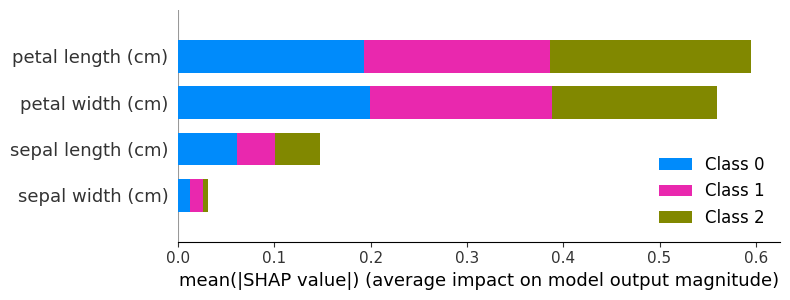

PSI per feature: {'sepal length (cm)': 0.32046551518874355, 'sepal width (cm)': 0.04503798861694733, 'petal length (cm)': 2.5630311953953626, 'petal width (cm)': 2.8958386665261706}


In [10]:
# ===========================================
# Explainability (SHAP) and Drift (PSI)
# ===========================================
!pip install -q shap

import shap, numpy as np, json
from sklearn.datasets import load_iris
from statistics import median

iris = load_iris()
X, y, feature_names = iris.data, iris.target, iris.feature_names

# Use v2 model here as example (tree-based SHAP is faster)
m = joblib.load("v2_rf.joblib")

# SHAP summary for a small background set
explainer = shap.TreeExplainer(m)
background = shap.sample(X, 100, random_state=42)
shap_values = explainer(background)

# Plot summary (Colab inline)
shap.summary_plot(shap_values, background, feature_names=feature_names, show=True)

# PSI computation between baseline (train set) and production batch (features in logs)
def psi(expected, actual, bins=10):
    expected = np.asarray(expected, dtype=float)
    actual = np.asarray(actual, dtype=float)
    # Create bin edges on expected distribution
    qs = np.linspace(0, 100, bins+1)
    edges = np.percentile(expected, qs)
    edges[0] = -np.inf; edges[-1] = np.inf
    e_hist, _ = np.histogram(expected, bins=edges)
    a_hist, _ = np.histogram(actual, bins=edges)
    e_ratio = e_hist / e_hist.sum() if e_hist.sum() > 0 else np.ones_like(e_hist)/len(e_hist)
    a_ratio = a_hist / a_hist.sum() if a_hist.sum() > 0 else np.ones_like(a_hist)/len(a_hist)
    # Add small value to avoid log(0)
    e_ratio = np.clip(e_ratio, 1e-6, 1.0)
    a_ratio = np.clip(a_ratio, 1e-6, 1.0)
    return float(np.sum((a_ratio - e_ratio) * np.log(a_ratio / e_ratio)))

# Collect recent production features from the monitoring log
with open("ab_test_log.json", "r") as f:
    prod = json.load(f)
prod_features = np.array([row["features"] for row in prod], dtype=float)

# Compute PSI per feature
psi_scores = {}
for j, name in enumerate(feature_names):
    psi_scores[name] = psi(X[:, j], prod_features[:, j])

print("PSI per feature:", psi_scores)

# Simple drift rule-of-thumb thresholds
# PSI < 0.1: no drift; 0.1–0.25: moderate drift; >0.25: significant drift


## The results:

The graphs summarize the performance comparison between two deployed model versions (`v1` – Logistic Regression and `v2` – Random Forest) during the A/B testing and explainability phases.

1. **Accuracy by Variant**
   The bar chart shows that both models achieved **high classification accuracy** on the Iris dataset, with **v1 slightly outperforming v2**. This indicates that the baseline logistic regression model remains competitive despite the added complexity of the Random Forest.

2. **Latency Histogram**
   The histogram compares **response times (latency)** for each model during live API calls.

   * Both models respond in the **600–850 ms** range.
   * Model `v1` (blue) shows more stable and consistent latency, while `v2` (orange) has a wider spread, reflecting its heavier computation.

3. **SHAP Feature Importance Summary**
   The SHAP summary plot highlights which input features most strongly influence predictions in model `v2`.

   * **Petal length** and **petal width** have the **highest average impact** on predictions.
   * **Sepal length** and **sepal width** contribute less, confirming the known biological separation of Iris species primarily by petal measurements.

Overall, the results demonstrate that both versions perform well, with model `v1` offering slightly better latency and accuracy, while model `v2` provides richer interpretability and stronger reliance on biologically meaningful features.
